# MAE 271: Lab 1 - Quarter car simulation over bump
### Cooper Cook & Joshua Booth

![alt text](IMG_0967.jpg)


![alt text](IMG_0968.jpg)

The above graphics show the quarter car model with associated bond graph and descriptive equations for the system itself. The bump diagram is also drawn and the descriptive equations for that modeling are shown as well. 

The goal of the following lab project to follow is to analyze the above system for both linear and non-linear spring functions. As well as varying parameters of bump-height and car velocity to display the differences in responses to the spring characteristics in the system. 

Define global parameters and initial conditions for the system

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -----------------------------
# Global Parameters
# -----------------------------
mt = 3500 / 2.2            # total mass [kg]
msmus = 5                 # sprung/unsprung mass ratio
mus = mt / (1 + msmus)    # unsprung mass [kg]
ms = mt - mus             # sprung mass [kg]

ks = ms * (2 * np.pi * 1)**2        # suspension stiffness
bs = 2 * 0.5 * np.sqrt(ks * ms)     # suspension damping
kt = mus * (2 * np.pi * 8)**2       # tire stiffness
g = 9.8                             # gravity [m/s^2]

# Road input parameters
#A = 2 * 0.0254          # bump height [m]
d = 3 * 0.3048          # bump length [m]
#u = 30 * 0.46           # vehicle speed [m/s]

# Nonlinear spring toggle
# non_lin = 0
# G = (ks / (3 * (ms * g)**(2/3)))**3

# # Initial conditions: [ps, pus, qs, qt]
# if non_lin == 1:
#     initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
# else:
#     initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

# Time span
t_span = (0, 1)
t_eval = np.arange(0, 1.001, 0.001)

results = []  # store all simulation cases

Run through the different parameters with the varying bump and speed

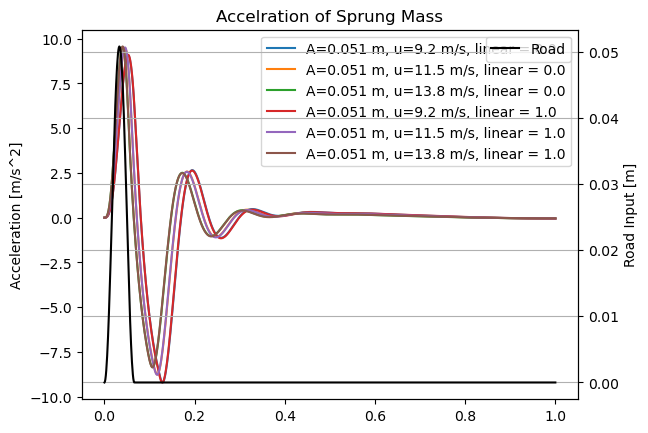

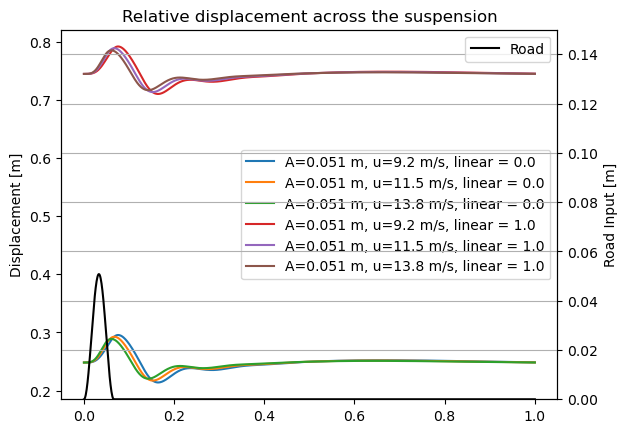

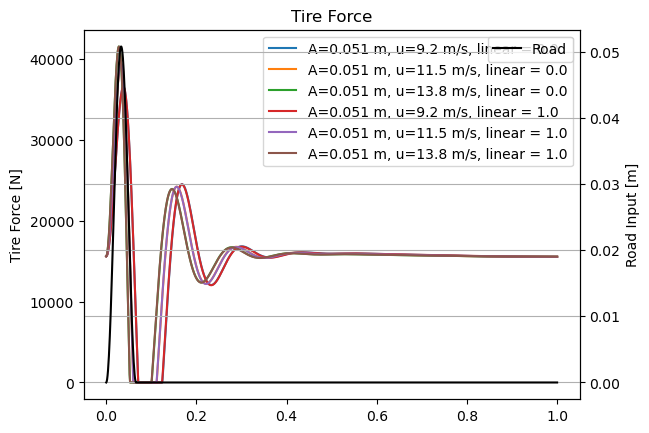

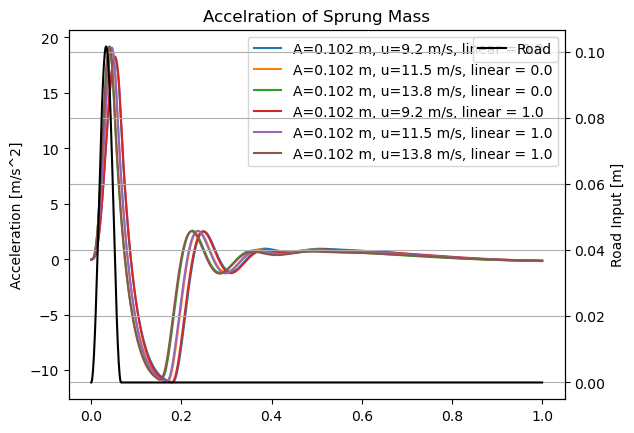

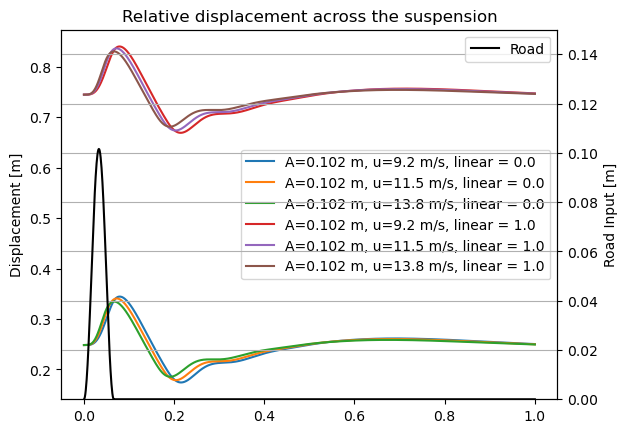

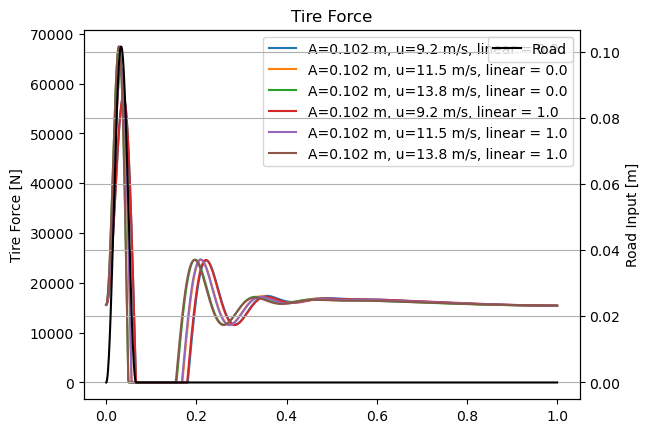

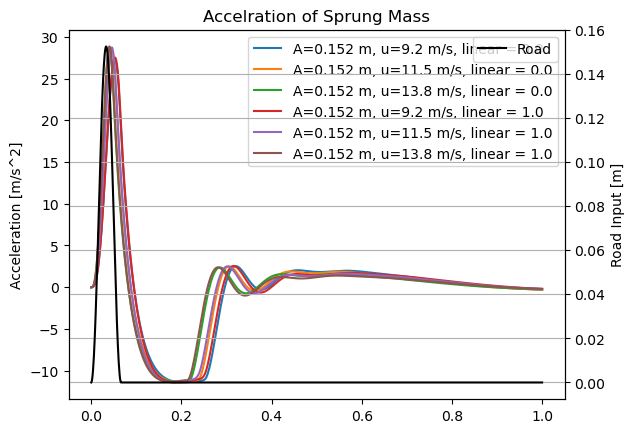

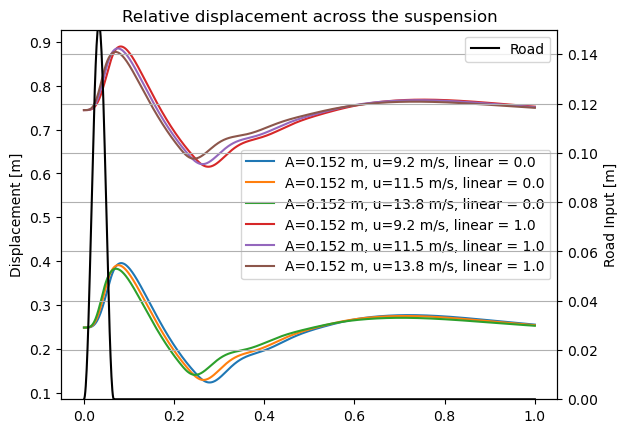

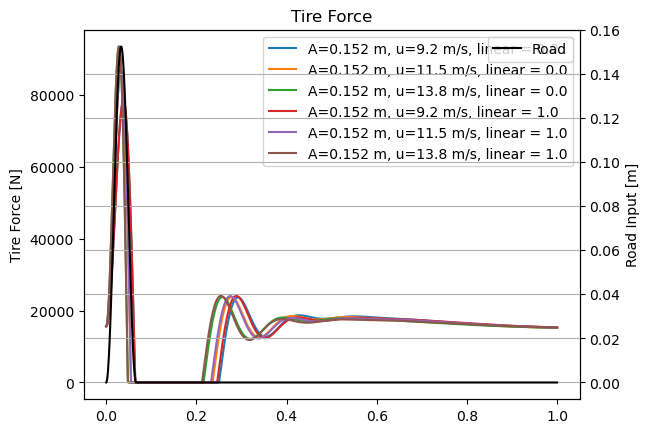

In [12]:
# A = 2in bump height
for A in [2*0.0254]:   # Loop through varying bump heights , 4*0.0254, 6*0.0254
    results_A_2 = []  # store all simulation cases
    for n in [0,1]:
        # Nonlinear spring toggle
        non_lin = n
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if non_lin == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
            # -----------------------------
            # Model Function
            # -----------------------------
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if non_lin == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results

            results_A_2.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": non_lin
            })
            # print(results)

    # Plot Results

    # Sprung masss acceleration
    plt.figure()
    for r in results_A_2:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Accelration of Sprung Mass')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_2:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["qs"]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend()
    plt.title('Relative displacement across the suspension')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_2:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Tire Force')
    plt.grid(True)
    plt.show()

# A = 4in bump height
for A in [4*0.0254]:   # Loop through varying bump heights , 4*0.0254, 6*0.0254
    results_A_4 = []
    for n in [0,1]:
        # Nonlinear spring toggle
        non_lin = n
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if non_lin == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
            # -----------------------------
            # Model Function
            # -----------------------------
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if non_lin == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results

            results_A_4.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": non_lin
            })
            # print(results)

    # Plot Results

    # Sprung masss acceleration
    plt.figure()
    for r in results_A_4:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Accelration of Sprung Mass')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_4:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["qs"]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend()
    plt.title('Relative displacement across the suspension')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_4:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Tire Force')
    plt.grid(True)
    plt.show()

# A = 6in bump height
for A in [6*0.0254]:   # Loop through varying bump heights , 4*0.0254, 6*0.0254
    results_A_6 = []
    for n in [0,1]:
        # Nonlinear spring toggle
        non_lin = n
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if non_lin == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
            # -----------------------------
            # Model Function
            # -----------------------------
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if non_lin == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results

            results_A_6.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": non_lin
            })
            # print(results)

    # Plot Results

    # Sprung masss acceleration
    plt.figure()
    for r in results_A_6:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Accelration of Sprung Mass')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_6:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["qs"]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend()
    plt.title('Relative displacement across the suspension')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure()
    for r in results_A_6:
        label = f"A={r['A']:.3f} m, u={r['u']:.1f} m/s, linear = {r['lin']:.1f}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title('Tire Force')
    plt.grid(True)
    plt.show()